In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import pickle

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


In [42]:

def cargar_y_preparar_datos(archivo_csv=None, data_string=None):
    """
    Carga y prepara los datos desde CSV o string
    """
    print("=== CARGANDO DATOS ===")

    if data_string:
        # Si se proporciona data como string (para testing)
        from io import StringIO
        df = pd.read_csv(StringIO(data_string), header=None)
        df.columns = ['produccion', 'area', 'PRECTOTCORR_SUM', 'RH2M', 'T2M',
                     'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'WS2M', 'fecha', 'canton_id']
    else:
        df = pd.read_csv(archivo_csv)

    # Convertir fecha
    df['fecha'] = pd.to_datetime(df['fecha'])
    df = df.sort_values('fecha')

    # Filtrar datos: mantener solo desde 2009 en adelante
    df = df[df['fecha'].dt.year >= 2009]
    print(f"Datos filtrados desde 2009: {df.shape}")

    # Rellenar valores nulos
    columnas_numericas = ['produccion', 'area', 'PRECTOTCORR_SUM', 'RH2M', 'T2M',
                         'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'WS2M']

    for col in columnas_numericas:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    # Agregar características temporales
    df['mes'] = df['fecha'].dt.month
    df['año'] = df['fecha'].dt.year

    print(f"Datos cargados: {df.shape}")
    print(f"Rango fechas: {df['fecha'].min()} a {df['fecha'].max()}")

    return df

def grafico_exploratorio_simple(df):
    """
    Gráfico simple de exploración
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(df['fecha'], df['produccion'], linewidth=1, color='blue')
    plt.title('Producción en el Tiempo')
    plt.xlabel('Fecha')
    plt.ylabel('Producción')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.hist(df['produccion'], bins=20, color='green', alpha=0.7)
    plt.title('Distribución Producción')
    plt.xlabel('Producción')
    plt.ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()

=== CARGANDO DATOS ===
Datos filtrados desde 2009: (990, 12)
Datos cargados: (990, 14)
Rango fechas: 2009-01-01 00:00:00 a 2025-06-01 00:00:00


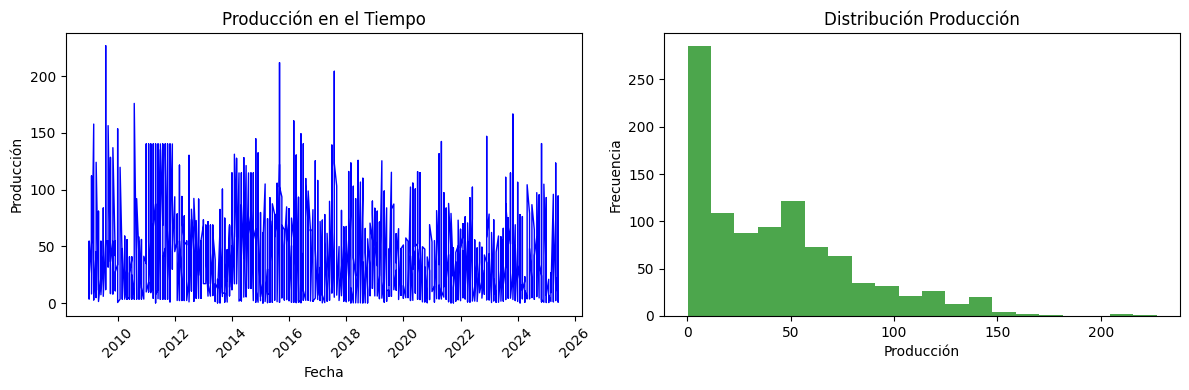

In [43]:
df = cargar_y_preparar_datos("C:/Template-AgroIA/data/processed/rnn/rnn_produccion.csv")
grafico_exploratorio_simple(df)

In [55]:
def preparar_datos_lstm(df, ventana_tiempo=24):
    """
    Prepara datos para LSTM
    """
    print(f"\n=== PREPARANDO DATOS LSTM ===")
    print(f"Ventana temporal: {ventana_tiempo} meses")

    # Características a usar
    columnas_features = ['area', 'PRECTOTCORR_SUM', 'RH2M', 'T2M', 'T2MDEW',
                        'T2MWET', 'T2M_MAX', 'T2M_MIN', 'WS2M', 'mes']
    columna_target = 'produccion'

    # Preparar datos
    data = df[columnas_features + [columna_target]].values

    # Normalizar
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # Crear secuencias
    X, y = [], []
    for i in range(ventana_tiempo, len(data_scaled)):
        X.append(data_scaled[i-ventana_tiempo:i, :-1])  # Features
        y.append(data_scaled[i, -1])  # Target

    X, y = np.array(X), np.array(y)

    # Dividir datos
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    print(f"Entrenamiento: {X_train.shape}")
    print(f"Prueba: {X_test.shape}")

    return X_train, X_test, y_train, y_test, scaler, columnas_features


In [56]:
 X_train, X_test, y_train, y_test, scaler, columnas_features = preparar_datos_lstm(df)


=== PREPARANDO DATOS LSTM ===
Ventana temporal: 24 meses
Entrenamiento: (772, 24, 10)
Prueba: (194, 24, 10)


In [83]:
def crear_modelo_lstm(input_shape):
    """
    Crea modelo LSTM optimizado para mejor rendimiento
    """
    print(f"\n=== CREANDO MODELO LSTM ===")

    model = Sequential([
        LSTM(96, return_sequences=True, input_shape=input_shape,
             activation='tanh',
             kernel_initializer='glorot_uniform',
             recurrent_initializer='orthogonal',
             kernel_regularizer=tf.keras.regularizers.l2(0.0003),
             recurrent_regularizer=tf.keras.regularizers.l2(0.0003)),
        Dropout(0.2),

        LSTM(48, return_sequences=False,
             activation='tanh',
             kernel_initializer='glorot_uniform',
             recurrent_initializer='orthogonal',
             kernel_regularizer=tf.keras.regularizers.l2(0.0003),
             recurrent_regularizer=tf.keras.regularizers.l2(0.0003)),
        Dropout(0.25),

        Dense(24, activation='relu'),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007, clipnorm=1.0),
        loss='mse',
        metrics=['mae']
    )

    print("Modelo creado:")
    print(f"Parámetros: {model.count_params():,}")
    return model


def entrenar_modelo(model, X_train, y_train, X_test, y_test):
    """
    Entrena el modelo con configuración optimizada
    """
    print(f"\n=== ENTRENANDO MODELO ===")

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=40,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.8,
        patience=15,
        min_lr=0.00001,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=300,
        batch_size=24,
        callbacks=[early_stopping, reduce_lr],
        verbose=1,
        shuffle=True
    )

    return history

In [84]:
 # 3. Crear y entrenar modelo
model = crear_modelo_lstm((X_train.shape[1], X_train.shape[2]))
history = entrenar_modelo(model, X_train, y_train, X_test, y_test)



=== CREANDO MODELO LSTM ===
Modelo creado:
Parámetros: 70,129

=== ENTRENANDO MODELO ===
Epoch 1/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1474 - mae: 0.1916 - val_loss: 0.0991 - val_mae: 0.1385 - learning_rate: 7.0000e-04
Epoch 2/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1003 - mae: 0.1406 - val_loss: 0.0825 - val_mae: 0.1284 - learning_rate: 7.0000e-04
Epoch 3/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0892 - mae: 0.1465 - val_loss: 0.0722 - val_mae: 0.1306 - learning_rate: 7.0000e-04
Epoch 4/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0759 - mae: 0.1388 - val_loss: 0.0690 - val_mae: 0.1482 - learning_rate: 7.0000e-04
Epoch 5/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0694 - mae: 0.1410 - val_loss: 0.0598 - val_mae: 0.1377 - learning_rate: 7.0000e-04
Epoch 6/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0651 - mae: 0.1466 - val_loss: 0.0546 - val_mae: 0.1356 - learning_rate: 7.0000e-04
Epoch 7/300
33/33 ━━━━━━━━━━━━━━━━

In [88]:
def evaluar_modelo(model, X_test, y_test, scaler):
    """
    Evalúa el modelo
    """
    print(f"\n=== EVALUANDO MODELO ===")

    # Predicciones
    y_pred = model.predict(X_test, verbose=0)

    # Desnormalizar
    n_features = scaler.n_features_in_
    target_idx = n_features - 1

    # Crear arrays temporales para desnormalizar
    temp_test = np.zeros((len(y_test), n_features))
    temp_test[:, target_idx] = y_test
    y_test_real = scaler.inverse_transform(temp_test)[:, target_idx]

    temp_pred = np.zeros((len(y_pred), n_features))
    temp_pred[:, target_idx] = y_pred.flatten()
    y_pred_real = scaler.inverse_transform(temp_pred)[:, target_idx]

    # Métricas
    mse = mean_squared_error(y_test_real, y_pred_real)
    mae = mean_absolute_error(y_test_real, y_pred_real)
    r2 = r2_score(y_test_real, y_pred_real)
    rmse = np.sqrt(mse)

    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    return y_test_real, y_pred_real

def graficos_evaluacion_simples(history, y_test_real, y_pred_real):
    """
    Gráficos simples de evaluación
    """
    plt.figure(figsize=(15, 4))

    # Pérdida
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Entrenamiento', color='blue')
    plt.plot(history.history['val_loss'], label='Validación', color='red')
    plt.title('Pérdida del Modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)







=== EVALUANDO MODELO ===
MSE: 1152.8011
RMSE: 33.9529
MAE: 27.2264
R²: -0.0123


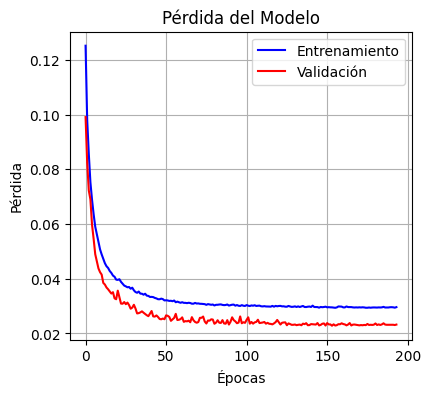

In [89]:
 # 4. Evaluar
y_test_real, y_pred_real = evaluar_modelo(model, X_test, y_test, scaler)
graficos_evaluacion_simples(history, y_test_real, y_pred_real)


In [90]:
def predecir_futuro(model, X_test, scaler, meses_futuro=6):
    """
    Predice valores futuros
    """
    print(f"\n=== PREDICIENDO {meses_futuro} MESES FUTUROS ===")

    # Última secuencia
    ultima_secuencia = X_test[-1].copy()
    predicciones = []

    for i in range(meses_futuro):
        # Predicción
        pred = model.predict(ultima_secuencia.reshape(1, *ultima_secuencia.shape), verbose=0)
        predicciones.append(pred[0, 0])

        # Actualizar secuencia
        nueva_fila = ultima_secuencia[-1].copy()
        nueva_fila[-1] = pred[0, 0]  # Actualizar mes (última característica)
        ultima_secuencia = np.vstack([ultima_secuencia[1:], nueva_fila])

    # Desnormalizar
    n_features = scaler.n_features_in_
    target_idx = n_features - 1

    temp_pred = np.zeros((len(predicciones), n_features))
    temp_pred[:, target_idx] = predicciones
    predicciones_reales = scaler.inverse_transform(temp_pred)[:, target_idx]

    return predicciones_reales

def grafico_predicciones_simples(df, predicciones_futuras, meses_futuro=6):
    """
    Gráfico simple de predicciones futuras
    """
    # Fechas futuras
    ultima_fecha = df['fecha'].max()
    fechas_futuras = pd.date_range(start=ultima_fecha + pd.DateOffset(months=1),
                                  periods=meses_futuro, freq='M')

    # Datos recientes
    df_reciente = df.tail(36)  # Últimos 3 años

    plt.figure(figsize=(12, 5))

    plt.plot(df_reciente['fecha'], df_reciente['produccion'],
             label='Histórico', color='blue', linewidth=2)

    plt.plot(fechas_futuras, predicciones_futuras,
             label='Predicción', color='red', linewidth=2,
             linestyle='--', marker='o', markersize=6)

    plt.title('Predicciones Futuras - 6 Meses')
    plt.xlabel('Fecha')
    plt.ylabel('Producción')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Valores numéricos
    print(f"\nPredicciones próximos {meses_futuro} meses:")
    for i, (fecha, pred) in enumerate(zip(fechas_futuras, predicciones_futuras)):
        print(f"  {fecha.strftime('%Y-%m')}: {pred:.2f}")



=== PREDICIENDO 6 MESES FUTUROS ===


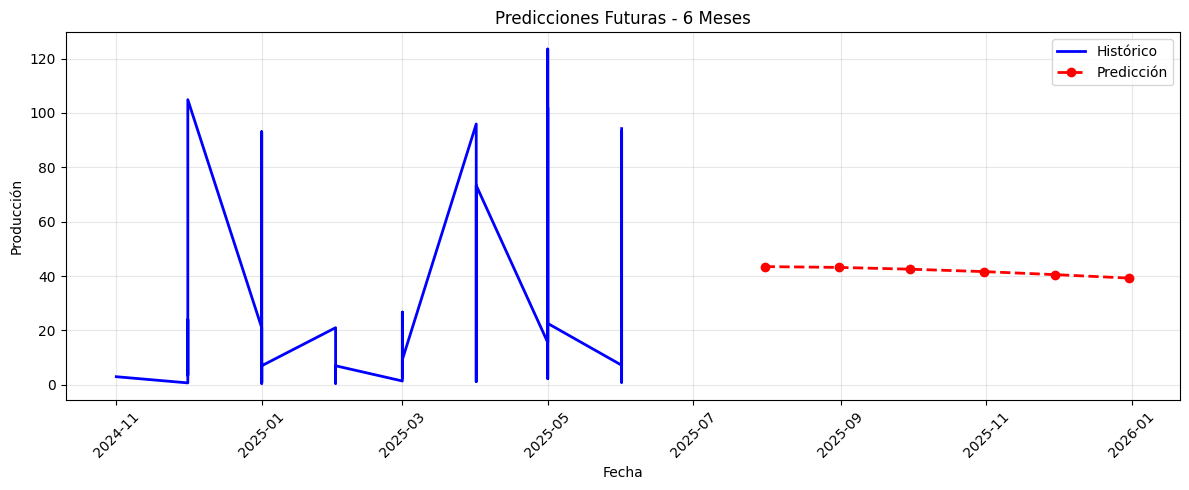


Predicciones próximos 6 meses:
  2025-07: 43.47
  2025-08: 43.18
  2025-09: 42.52
  2025-10: 41.63
  2025-11: 40.52
  2025-12: 39.23


In [91]:
predicciones_futuras = predecir_futuro(model, X_test, scaler, meses_futuro=6)
grafico_predicciones_simples(df, predicciones_futuras)

In [97]:

def exportar_modelo(model, scaler, columnas_features, nombre_base='modelo_lstm_produccion'):
    """
    Exporta el modelo en formato .keras junto con el scaler y columnas usadas.
    Guarda todo en el directorio actual (ej: src/train/).
    """
    print(f"\n=== EXPORTANDO MODELO ===")

    # Guardar modelo .keras
    modelo_path = f"{nombre_base}.keras"
    model.save(modelo_path)
    print(f"Modelo guardado en: {modelo_path}")

    # Guardar scaler y columnas
    info_path = f"{nombre_base}_info.pkl"
    with open(info_path, "wb") as f:
        pickle.dump({"scaler": scaler, "features": columnas_features}, f)
    print(f"Scaler y metadatos guardados en: {info_path}")

In [98]:
 # 6. Exportar modelo
exportar_modelo(model, scaler, columnas_features)


=== EXPORTANDO MODELO ===
Modelo guardado en: modelo_lstm_produccion.keras
Scaler y metadatos guardados en: modelo_lstm_produccion_info.pkl
